<a href="https://colab.research.google.com/github/kconstable/market_predictions/blob/main/market_data_av.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [68]:
import sys
# !{sys.executable} -m pip install plotly

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import pickle
from datetime import date, timedelta,datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files

# alphavalue key
key = '2Y4KISB4XMRRRPW7'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cypto Currencies

In [ ]:
def get_crypto_intraday(symbol,key,interval='60min',outputsize='compact',market='USD'):
  """
  CRYPTO_INTRADAY
    symbol: DOGE, BTC, ETH
    key: apikey
    interval: 1min, 5min, 15min, 30min, 60min
    outputsize: compact(last 100), full (all)
    market: USD
  """

  # build query string, get data as json and convert to a dict
  url = f"https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol={symbol}&market={market}&interval={interval}&outputsize={outputsize}&apikey={key}"
  r = requests.get(url)
  d = r.json()

  # extract data to df
  df=pd.DataFrame(d[f'Time Series Crypto ({interval})']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Digital Currency Code']
  df['name'] = d['Meta Data']['3. Digital Currency Name']

  return df

In [ ]:
# def get_crypto_data(symbol,key):
#   """
#   'ETH', 'BTC', 'DOGE'
#   """
#   # build query string, get data as json and convert to a dict
#   url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CAD&apikey={key}'
#   r = requests.get(url)
#   d = r.json()

#   # extract data to df
#   df=pd.DataFrame(d['Time Series (Digital Currency Daily)']).T

#   # remove columns not required
#   # returns the price in two currencies, just keep USD
#   cols = [c for c in df.columns if '(CAD)' not in c]
#   df=df.loc[:, cols]
#   df.columns = ['open','high','low','close','volume','marketcap']

#   # add the cyrpto name
#   df['name'] = d['Meta Data']['3. Digital Currency Name']

#   return df


## Stocks

In [2]:
def get_ticker_data(symbol,key,outputsize='compact',throttle=0):
  """
  Returns daily data for a stock (symbol)
    outputsize: compact(last 100) or full (20 years)
    key: apikey
    symbols: OILK (oil ETF),BAR(gold ETF),VXZ (volatility ETF)
  """
  url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={key}'
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract data to a df
  df = pd.DataFrame(d['Time Series (Daily)']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Symbol']

  # change data types
  df.index = pd.to_datetime(df.index)

  # convert datatype to float
  for col in ['open','high','low','close','volume']:
    df[col] = df[col].astype('float')

  # Print Results
  missing = sum(df.close.isna())
  total = df.shape[0]
  print(f"Ticker:{symbol}")
  print("---"*10)
  print(f"=>Missing Data:{missing:10}")
  print(f"=>Total Data:{total:10}")
  print(f"=>Percent Missing:{round(missing/total*100,2):10}%\n")

  return df


## Economic Indicators

In [7]:
def get_economic_indicators(funct,key,interval=None,maturity=None,throttle=0):
  """
  Returns Economic Indicator Data with missing values interpolated between dates
  Monthly Data:
    NONFARM_PAYROLL, INFLATION_EXPECTATION,CONSUMER_SENTIMENT,UNEMPLOYMENT
  Daily, Weekly, Monthly Data:  
    FEDERAL_FUNDS_RATE = interval (daily,weekly,monthly)
    TREASURY_YIELD = interval (daily, weekly, monthly), 
                     maturity (3month, 5year, 10year, and 30year)
  """
  
  # query strings
  # Monthly Data:
  if funct in ['NONFARM_PAYROLL','INFLATION_EXPECTATION','CONSUMER_SENTIMENT','UNEMPLOYMENT']:
    url = f'https://www.alphavantage.co/query?function={funct}&apikey={key}'

  # Daily, Weekly or Monthly Data:
  # Interest Rates
  if funct == 'FEDERAL_FUNDS_RATE':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&apikey={key}'

  # Treasury Yield  
  if funct == 'TREASURY_YIELD':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&maturity={maturity}&apikey={key}'

  # pull data
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # convert to df
  df = pd.DataFrame(d['data'])

  # move date to a datetime index
  df.date = pd.to_datetime(df.date)
  df.set_index('date',inplace=True)

  # add the ticker name and frequency
  df['name'] = d['name']
  df['interval']=d['interval'] 

  # clean data & interpolate missing values
  # missing data encoded with '.'
  # change datatype to float
  df.replace('.',np.nan,inplace=True)
  df.value = df.value.astype('float')

  # missing data stats
  missing =sum(df.value.isna())
  total =df.shape[0]

  # interpolate using the time index
  if missing >0:
    df.value.interpolate(method='time',inplace=True)

  # Print Status
  print(f"{funct}:")
  print("----"*10)
  print(f"=>Missing Values:{missing}")
  print(f"=>Total Values:{total}")
  print(f"=>Percent Interpolated:{round(missing/total*100,2)}%\n")

  return df



## Technical Indicators

In [4]:
def get_technical_indicators(symbol,funct,key,interval,time_period=None,throttle=0):
  """
  Returns Technical Indicators (only works for stocks, not cyrpto)
  MACD:   symbol,interval
  RSI:    symbol,interval,time_period
  BBANDS: symbol,interval,time_period

  Parameters:
          interval: (1min, 5min, 15min, 30min, 60min, daily, weekly, monthly)
          series_type: (open, close,high,low)-default to close
          timer_periods: Integer
  """
  # build the query string
  if funct =='MACD':
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&apikey={key}'
  if funct in ['RSI','BBANDS']:
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&time_period={time_period}&apikey={key}'

  # request data as json, convert to dict, pause request to avoid the data throttle
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract to a df, add the indicator name, convert the index to datetime
  df = pd.DataFrame(d[f'Technical Analysis: {funct}']).T
  df.index = pd.to_datetime(df.index)

  # convert the data to float
  for col in df.columns:
    df[col] = df[col].astype('float')

  # check for missing data
  missing = df.isnull().any().sum()
  total = len(df)

  # Print Status
  print(f"{funct}:")
  print("----"*10)
  print(f"=>Missing Values:{missing}")
  print(f"=>Total Values:{total}")
  print(f"=>Percent Missing:{round(missing/total*100,2)}%\n")

  return df

## Combine Stock Data
+ price data
+ economic
+ technical

In [9]:
def get_consolidated_stock_data(symbol,key,config,outputsize='compact',throttle=5):
  """
  5 API requests per minute and 500 requests per day
  """

  # Get stock prices
  dff  = get_ticker_data(symbol,key,outputsize,0)

  # Get Commodity prices
  # ****************************************************************************
  for commodity in config['Commodities']:
    try:
      # get prices
      df = get_ticker_data(commodity,key,outputsize,throttle)

      # rename close to commodity name, remove unneeded columns and join with 
      # the stock prices by date
      df.rename(columns={'close':commodity},inplace=True)
      df.drop(['open','high','low','volume','symbol'],axis=1,inplace=True)
      dff = dff.join(df,how='left')
    except:
      print(f"Error===>{commodity}")


  # Economic Indicators
  # ****************************************************************************
  # loop through the config to pull the requested data
  for indicator,values in config['Economic'].items():
    if indicator == 'TREASURY_YIELD':
      for tr in values:
        try:
          df = get_economic_indicators(indicator,key,interval=tr['interval'],maturity=tr['maturity'],throttle=throttle)
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": tr['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}:{tr['maturity']}")
   
    else: 
      # daily
      if values['interval']=='daily':
        try:
          df = get_economic_indicators(indicator,key,interval=values['interval'],throttle=throttle)
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")
  
      else: 
        try:
          # monthly or weekly
          df = get_economic_indicators(indicator,key,throttle=throttle)

          # reindex to daily, fill missing values forward
          days = pd.date_range(start = min(df.index),end =max(df.index),freq='D')
          df =df.reindex(days,method = 'ffill')
      
          # join with the other data
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")

  # # Technical Indicators
  # ****************************************************************************
  for indicator,values in config['Technical'].items():
    df = get_technical_indicators(symbol,indicator,key,values['interval'],values['time_period'],throttle)
    dff = dff.join(df,how='left')
  
  # clean column names
  dff.rename(columns={"Real Upper Band":'b-upper',
                      "Real Lower Band":'b-lower',
                      "Real Middle Band":"b-middle",
                      "RSI":"rsi",
                      "MACD_Hist":"macd_hist",
                      "MACD_Signal":"macd_signal",
                      "MACD":"macd"
                      },inplace=True)
      

  # Fill in any missing data after joining all datasets
  dff.fillna(method='bfill',inplace=True,axis = 0)

  return dff

In [23]:
# Get Consolidated Data
config ={'Economic':
         {'TREASURY_YIELD':[{'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'5year','name':'yield5y'}],
          'FEDERAL_FUNDS_RATE':{'interval':'daily','name':'ir'},
          'NONFARM_PAYROLL':{'interval':'monthly','name':'nfp'},
          'UNEMPLOYMENT':{'interval':'monthly','name':'unemployment'},
          'CONSUMER_SENTIMENT':{'interval':'monthly','name':'cs'},
          'INFLATION_EXPECTATION':{'interval':'monthly','name':'infl'},
          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':10},
           'RSI':{'interval':'daily','time_period':60},
           'MACD':{'interval':'daily','time_period':60}
           },
         'Commodities':['BAR','OILK','VXZ']
         }

dff = get_consolidated_stock_data('BLX',key,config,throttle=30,outputsize='full')
dff.head()

dff.to_pickle("market_data_all.pickle")
dff.to_csv("market_data_all.csv")

Ticker:BLX
------------------------------
=>Missing Data:         0
=>Total Data:      5492
=>Percent Missing:       0.0%

Ticker:BAR
------------------------------
=>Missing Data:         0
=>Total Data:      1005
=>Percent Missing:       0.0%

Ticker:OILK
------------------------------
=>Missing Data:         0
=>Total Data:      1238
=>Percent Missing:       0.0%

Ticker:VXZ
------------------------------
=>Missing Data:         0
=>Total Data:       910
=>Percent Missing:       0.0%

TREASURY_YIELD:
----------------------------------------
=>Missing Values:663
=>Total Values:15563
=>Percent Interpolated:4.26%

TREASURY_YIELD:
----------------------------------------
=>Missing Values:663
=>Total Values:15563
=>Percent Interpolated:4.26%

FEDERAL_FUNDS_RATE:
----------------------------------------
=>Missing Values:0
=>Total Values:24529
=>Percent Interpolated:0.0%

NONFARM_PAYROLL:
----------------------------------------
=>Missing Values:0
=>Total Values:991
=>Percent Interpolated:

## Save Files to Local

In [24]:
# Save as pickle File


dff.to_pickle("market_data_df.pickle")

# save to local drive
# files.download("market_data.csv")
# files.download('market_data.pickle')

In [26]:
# upload files from local
# uploaded = files.upload()


df = pd.read_pickle('market_data_all.pickle')

df.head()


open   high     low  ...    macd  macd_hist macd_signal
2021-08-27  16.60  17.14  16.510  ...  0.2459    -0.0334      0.2793
2021-08-26  16.59  16.88  16.482  ...  0.2238    -0.0639      0.2877
2021-08-25  16.43  16.90  16.360  ...  0.2361    -0.0676      0.3037
2021-08-24  16.61  16.62  16.430  ...  0.2494    -0.0712      0.3206
2021-08-23  16.54  16.72  16.400  ...  0.2729    -0.0655      0.3384

[5 rows x 23 columns]

## Visualizations

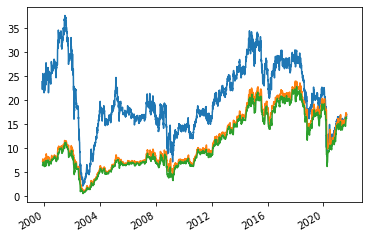

In [27]:
dff.close.plot()
dff['b-upper'].plot()
dff['b-lower'].plot()


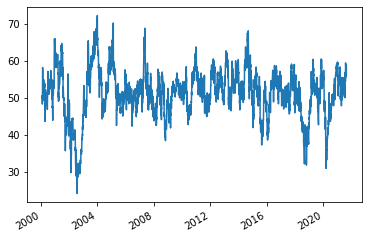

In [82]:
dff["rsi"].plot()

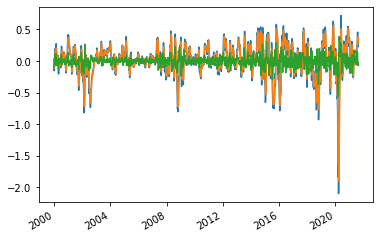

In [83]:
dff['macd'].plot()
dff['macd_signal'].plot()
dff['macd_hist'].plot()

In [84]:
dff.cs.plot()

In [28]:
dff.ir.plot()
dff.yield10y.plot()
dff.yield5y.plot()

In [32]:
def plot_candlestick(df):
    """
    
    """
    # get ticker name
    name = df.symbol.unique()[0]
    
    # Create subplots
    fig = make_subplots(rows=6, cols=1, 
                        shared_xaxes=True, 
                        subplot_titles=('Prices: Open/High/Low/Close','Volume','Non-Farm Payroll','Consumer Sentiment','Expected Inflation','Unemployment'),
                        vertical_spacing=0.07)
                   
    # OHLC Plot
    fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high,low=df.low, close=df.close, 
                name="Price",
                increasing_line_color= 'rgba(26,150,65,1)', 
                decreasing_line_color= 'lightcoral'), 
                row=1, col=1)
    
    
    # area chart for volume
    fig.add_trace(go.Scatter(x=df.index, y=df.volume, 
                fill='tozeroy',
                name='Volume',
                mode='none',
                fillcolor='rgba(26,150,65,0.5)'),
                row=2,col=1)
    
    # Non-Farm Payrolls
    fig.add_trace(go.Scatter(x=df.index, y=df.nfp,name='Non-Farm Payroll'),
                  row=3,col=1)
    
    # Consumer Sentiment
    fig.add_trace(go.Scatter(x=df.index, y=df.cs,name='Consumer Sentiment'),
                  row=4,col=1)

    # Expected Inflation    
    fig.add_trace(go.Scatter(x=df.index, y=df.infl,name='Expected Inflation'),
                  row=5,col=1)
    
    # Unemployment    
    fig.add_trace(go.Scatter(x=df.index, y=df.unemployment,name='Unemployment'),
                  row=6,col=1)

    # Do not show OHLC's rangeslider plot 
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(template='plotly_white',
                      title = f"Price, Volume and Economic Indicators: {name}")
          
    fig.show()
    

In [33]:
plot_candlestick(dff)


In [34]:
# MACD
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index,y=dff['macd'],name='macd'))
fig.add_trace(go.Scatter(x=dff.index,y=dff['macd_signal'],name='Signal'))
fig.add_trace(go.Bar(x=dff.index,y=dff['macd_hist'],name='Hist',marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)'))
fig.show()

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index,y=dff['rsi'],name='RSI'))
# fig.add_shape(type='line',
#                 x0=0,
#                 y0=30,
#                 x1=1,
#                 y1=30,
#                 line=dict(color='#ccc',),
#                 xref='paper',
#                 yref='y'
# )
# fig.add_shape(type='line',
#                 x0=0,
#                 y0=70,
#                 x1=1,
#                 y1=70,
#                 line=dict(color='#ccc',),
#                 xref='paper',
#                 yref='y'
# )
fig.show()

In [41]:
dff.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'BAR',
       'OILK', 'VXZ', 'yield10y', 'yield5y', 'ir', 'nfp', 'cs', 'infl',
       'b-middle', 'b-upper', 'b-lower', 'rsi', 'macd_hist', 'macd_signal',
       'macd'],
      dtype='object')

In [36]:
# commodities
# df = dff.copy()
# df.reset_index(inplace=True,)
# df
dff.index
# dff.pct_change()
# pd.DataFrame(list(zip(dff.index,dff.loc[:,['close','OILK','BAR','VXZ']])))
dff

open   high     low  ...    macd  macd_hist macd_signal
2021-08-27  16.60  17.14  16.510  ...  0.2459    -0.0334      0.2793
2021-08-26  16.59  16.88  16.482  ...  0.2238    -0.0639      0.2877
2021-08-25  16.43  16.90  16.360  ...  0.2361    -0.0676      0.3037
2021-08-24  16.61  16.62  16.430  ...  0.2494    -0.0712      0.3206
2021-08-23  16.54  16.72  16.400  ...  0.2729    -0.0655      0.3384
...           ...    ...     ...  ...     ...        ...         ...
1999-11-05  22.38  22.38  22.190  ...     NaN        NaN         NaN
1999-11-04  22.88  22.88  22.250  ...     NaN        NaN         NaN
1999-11-03  23.50  23.50  22.940  ...     NaN        NaN         NaN
1999-11-02  23.69  23.81  23.630  ...     NaN        NaN         NaN
1999-11-01  24.06  24.06  23.810  ...     NaN        NaN         NaN

[5492 rows x 23 columns]

In [37]:
# Interest Rates
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index, y=dff['ir'],name='Federal Funds Rate'))
fig.add_trace(go.Scatter(x=dff.index, y=dff['yield10y'],name='10 Year Yield'))
fig.add_trace(go.Scatter(x=dff.index, y=dff['yield5y'],name='5 Year Yield'))
fig.show()

In [38]:
# Bollinger Bands

bb = dff[['b-middle','b-lower','b-upper']]

fig = go.Figure()
fig.add_trace(go.Scatter(x=bb.index,y=bb['b-upper'],name='upper bollinger',line_color="#ccc"))
fig.add_trace(go.Scatter(x=bb.index,y=bb['b-lower'],name='lower bollinger',line_color='#ccc',fill='tonexty'))
fig.add_trace(go.Scatter(x=bb.index,y=bb['b-middle'],name='Closing Price',line_color='blue'))
fig.show()

In [39]:
plot_candlestick(dff)